In [35]:
import polars as pl
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
import numpy as np
np.set_printoptions(suppress=True)
import joblib
import pandas

files = {}
for i in os.listdir('ml-32m'):
    file_name, ekst = i.split('.')
    if ekst == 'csv':
        df = pl.read_csv(f'ml-32m\\{i}')
        globals()[file_name] = df
        files[file_name] = df
        print(file_name, df.columns, sep = '\n')
        

In [38]:
ratings = pl.read_csv('ml-32m/ratings.csv')
movies = pl.read_csv('ml-32m/movies.csv')

In [41]:
ratings

userId,movieId,rating
i64,i64,f64
1,17,4.0
1,25,1.0
1,29,2.0
1,30,5.0
1,32,5.0
…,…,…
200948,79702,4.5
200948,79796,1.0
200948,80350,0.5


In [33]:
ratings

,userId,movieId,rating
0,1,17,4.0
1,1,25,1.0
2,1,29,2.0
3,1,30,5.0
4,1,32,5.0
...,...,...,...
32000199,200948,79702,4.5
32000200,200948,79796,1.0
32000201,200948,80350,0.5
32000202,200948,80463,3.5


In [6]:
ratings = ratings.lazy()
movies = movies.lazy()

### IZDVAJAM SAMO FILMOVE KOJI IMAJU VISE OD 30 OCENA

In [23]:
movies_for_sample = ratings.group_by('movieId').agg(pl.len().alias('#ratings_film')).filter(pl.col('#ratings_film') > 40)

### 10 FILMOVA SA NAJVISE OCENA 

In [26]:
movies_for_sample.join(movies, on = 'movieId', how = 'inner').sort('#ratings_film', descending= True).collect()[:10]

movieId,#ratings_film,title,genres
i64,u32,str,str
318,102929,"""Shawshank Redemption, The (199…","""Crime|Drama"""
356,100296,"""Forrest Gump (1994)""","""Comedy|Drama|Romance|War"""
296,98409,"""Pulp Fiction (1994)""","""Comedy|Crime|Drama|Thriller"""
2571,93808,"""Matrix, The (1999)""","""Action|Sci-Fi|Thriller"""
593,90330,"""Silence of the Lambs, The (199…","""Crime|Horror|Thriller"""
260,85010,"""Star Wars: Episode IV - A New …","""Action|Adventure|Sci-Fi"""
2959,77332,"""Fight Club (1999)""","""Action|Crime|Drama|Thriller"""
480,75233,"""Jurassic Park (1993)""","""Action|Adventure|Sci-Fi|Thrill…"
527,73849,"""Schindler's List (1993)""","""Drama|War"""


In [28]:
user = ratings.join(movies_for_sample, on = 'movieId', how = 'inner').sort(['movieId', 'userId'])

### AKO SE NE SORTIRA SEED NE RADI!

In [36]:
user_train = user.group_by('movieId').map_groups(lambda film: film.sample(40, seed = 42), schema = {'userId': pl.Int64,
                                                                                                 'movieId': pl.Int64,
                                                                                                 'rating': pl.Float64})

In [38]:
user_not_train = user.join(user_train.select(['userId', 'movieId']), on=['userId', 'movieId'], how='anti')

###  `user_not_train` ima 30 miliona redova, njega cu ostaviti u `.lazy`, a user_train vise nema potrebe da bude lazy

In [41]:
%%time
user_train = user_train.collect(engine= 'streaming')

CPU times: total: 39.4 s
Wall time: 11.6 s


In [43]:
user_train

userId,movieId,rating,#ratings_film
i64,i64,f64,u32
31854,1,3.5,68997
61093,1,4.0,68997
59420,1,3.5,68997
146238,1,4.0,68997
63860,1,5.0,68997
…,…,…,…
134909,290573,2.0,46
175333,290573,4.0,46
165364,290573,5.0,46


In [45]:
user_train['userId'].unique()

userId
i64
1
10
14
16
18
…
200933
200936
200940


In [47]:
movies = movies.collect()

In [49]:
movies = movies.with_columns(pl.col("genres").str.split("|"))

In [51]:
movies

movieId,title,genres
i64,str,list[str]
1,"""Toy Story (1995)""","[""Adventure"", ""Animation"", … ""Fantasy""]"
2,"""Jumanji (1995)""","[""Adventure"", ""Children"", ""Fantasy""]"
3,"""Grumpier Old Men (1995)""","[""Comedy"", ""Romance""]"
4,"""Waiting to Exhale (1995)""","[""Comedy"", ""Drama"", ""Romance""]"
5,"""Father of the Bride Part II (1…","[""Comedy""]"
…,…,…
292731,"""The Monroy Affaire (2022)""","[""Drama""]"
292737,"""Shelter in Solitude (2023)""","[""Comedy"", ""Drama""]"
292753,"""Orca (2023)""","[""Drama""]"


In [53]:
unique_genres = sorted(set(g for genre_list in movies["genres"] for g in genre_list))
print(unique_genres)

['(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [54]:
movies["genres"]

genres
list[str]
"[""Adventure"", ""Animation"", … ""Fantasy""]"
"[""Adventure"", ""Children"", ""Fantasy""]"
"[""Comedy"", ""Romance""]"
"[""Comedy"", ""Drama"", ""Romance""]"
"[""Comedy""]"
…
"[""Drama""]"
"[""Comedy"", ""Drama""]"
"[""Drama""]"


In [56]:
for genre in unique_genres:
    movies = movies.with_columns(pl.col("genres").list.contains(genre).cast(pl.Int8).alias(genre))
movies = movies.drop('genres')

In [59]:
movies

movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
i64,str,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
1,"""Toy Story (1995)""",0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"""Jumanji (1995)""",0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,"""Grumpier Old Men (1995)""",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,"""Waiting to Exhale (1995)""",0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,"""Father of the Bride Part II (1…",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
292731,"""The Monroy Affaire (2022)""",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292737,"""Shelter in Solitude (2023)""",0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292753,"""Orca (2023)""",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [61]:
movies = movies.with_columns(pl.col("title").str.extract(r"\((\d{4})\)", 1).cast(pl.Int16).alias("year"))

In [63]:
movies

movieId,title,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year
i64,str,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i16
1,"""Toy Story (1995)""",0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
2,"""Jumanji (1995)""",0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1995
3,"""Grumpier Old Men (1995)""",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1995
4,"""Waiting to Exhale (1995)""",0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1995
5,"""Father of the Bride Part II (1…",0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1995
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
292731,"""The Monroy Affaire (2022)""",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2022
292737,"""Shelter in Solitude (2023)""",0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2023
292753,"""Orca (2023)""",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2023


In [65]:
movies =movies.select(['movieId', 'title', 'year', *unique_genres])

In [67]:
movies

movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
i64,str,i16,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
1,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"""Jumanji (1995)""",1995,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,"""Grumpier Old Men (1995)""",1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,"""Waiting to Exhale (1995)""",1995,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,"""Father of the Bride Part II (1…",1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
292731,"""The Monroy Affaire (2022)""",2022,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292737,"""Shelter in Solitude (2023)""",2023,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292753,"""Orca (2023)""",2023,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


### ISTI FORMAT TABELE KAO MOVIES

In [70]:
user_zanr_train = user_train.join(movies, on='movieId', how='inner')

In [72]:
user_zanr_train

userId,movieId,rating,#ratings_film,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
i64,i64,f64,u32,str,i16,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
31854,1,3.5,68997,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
61093,1,4.0,68997,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
59420,1,3.5,68997,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
146238,1,4.0,68997,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
63860,1,5.0,68997,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
134909,290573,2.0,46,"""The Creator (2023)""",2023,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
175333,290573,4.0,46,"""The Creator (2023)""",2023,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
165364,290573,5.0,46,"""The Creator (2023)""",2023,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


### PIVOT LONGER --> ZANROVE PREBACUJEM U JEDNU KOLONU

In [75]:
user_longer = (user_zanr_train.unpivot(index=['userId', 'rating'],
                                       on=unique_genres).filter(pl.col('value') == 1).rename({'variable': 'genre', 'value': 'is_genre'}))

In [76]:
user_longer

userId,rating,genre,is_genre
i64,f64,str,i8
29223,5.0,"""(no genres listed)""",1
55955,2.5,"""(no genres listed)""",1
55575,0.5,"""(no genres listed)""",1
148749,4.0,"""(no genres listed)""",1
108778,3.5,"""(no genres listed)""",1
…,…,…,…
97750,1.5,"""Western""",1
29022,2.0,"""Western""",1
150126,1.5,"""Western""",1


In [79]:
user_longer.group_by(['userId', 'genre']).mean().sort(by='userId')

userId,genre,rating,is_genre
i64,str,f64,f64
1,"""Thriller""",2.0,1.0
1,"""Mystery""",2.0,1.0
1,"""Drama""",2.0,1.0
1,"""Crime""",2.0,1.0
10,"""Horror""",2.375,1.0
…,…,…,…
200943,"""Crime""",0.5,1.0
200943,"""Drama""",3.0,1.0
200943,"""Action""",1.0,1.0


### RACUNAM PROSEK ZA SVAKOG USERA ZA SVAKI ZANR I VRACAM U WIDE FORMAT

In [82]:
user_feature = (user_longer.group_by(['userId', 'genre']).agg(pl.col('rating').mean().alias('avg_rating_genre'))
                .pivot(index='userId', on='genre', values='avg_rating_genre').fill_null(0))

In [83]:
user_feature

userId,Horror,Romance,Thriller,Drama,Action,Musical,Sci-Fi,Comedy,Adventure,Animation,Crime,Fantasy,Film-Noir,IMAX,War,Documentary,Mystery,Western,Children,(no genres listed)
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
55660,2.5,3.5,2.5,3.416667,2.666667,4.0,0.0,2.625,3.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,3.25,0.0,3.5,0.0
19689,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124901,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38247,2.5,3.0,3.0,2.833333,3.0,0.0,3.0,2.75,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0
25936,0.0,3.5,3.0,3.285714,3.75,0.0,4.0,2.5,3.75,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
151918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149758,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [86]:
user_feature.filter(pl.col('Drama') > 0)['Drama'].mean()

3.578606798618759

In [88]:
movie_avg_rating = (user_train.group_by('movieId').agg(pl.col('rating').mean().alias('avg_rating')))

In [90]:
movie_avg_rating

movieId,avg_rating
i64,f64
104631,3.0875
227688,2.85
804,3.1125
26757,3.6375
3546,3.575
…,…
4841,3.2625
94752,3.825
43906,2.3125


In [92]:
movie_avg_rating.max()

movieId,avg_rating
i64,f64
290573,4.6125


In [94]:
movies

movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
i64,str,i16,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
1,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"""Jumanji (1995)""",1995,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,"""Grumpier Old Men (1995)""",1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,"""Waiting to Exhale (1995)""",1995,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,"""Father of the Bride Part II (1…",1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
292731,"""The Monroy Affaire (2022)""",2022,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292737,"""Shelter in Solitude (2023)""",2023,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292753,"""Orca (2023)""",2023,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [96]:
movie_features = movies.join(movie_avg_rating, on='movieId', how='left').fill_null(0)

In [98]:
movie_features

movieId,title,year,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,avg_rating
i64,str,i16,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,f64
1,"""Toy Story (1995)""",1995,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.7875
2,"""Jumanji (1995)""",1995,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3.2125
3,"""Grumpier Old Men (1995)""",1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,3.175
4,"""Waiting to Exhale (1995)""",1995,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,2.8875
5,"""Father of the Bride Part II (1…",1995,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3.0625
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
292731,"""The Monroy Affaire (2022)""",2022,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0
292737,"""Shelter in Solitude (2023)""",2023,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0
292753,"""Orca (2023)""",2023,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0


In [100]:
user_feature

userId,Horror,Romance,Thriller,Drama,Action,Musical,Sci-Fi,Comedy,Adventure,Animation,Crime,Fantasy,Film-Noir,IMAX,War,Documentary,Mystery,Western,Children,(no genres listed)
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
55660,2.5,3.5,2.5,3.416667,2.666667,4.0,0.0,2.625,3.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,3.25,0.0,3.5,0.0
19689,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124901,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38247,2.5,3.0,3.0,2.833333,3.0,0.0,3.0,2.75,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0
25936,0.0,3.5,3.0,3.285714,3.75,0.0,4.0,2.5,3.75,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
151918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149758,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
movie_features.sort('avg_rating')[-1]['movieId','title', 'avg_rating']

movieId,title,avg_rating
i64,str,f64
170705,"""Band of Brothers (2001)""",4.6125


In [104]:
user_train.filter(pl.col('movieId') == 858)['rating'].mean()

4.5

In [106]:
movie_features = movie_features.select(['movieId', 'title','year','avg_rating', *unique_genres])

In [108]:
movie_features

movieId,title,year,avg_rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
i64,str,i16,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
1,"""Toy Story (1995)""",1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,"""Jumanji (1995)""",1995,3.2125,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,"""Grumpier Old Men (1995)""",1995,3.175,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,"""Waiting to Exhale (1995)""",1995,2.8875,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0
5,"""Father of the Bride Part II (1…",1995,3.0625,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
292731,"""The Monroy Affaire (2022)""",2022,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292737,"""Shelter in Solitude (2023)""",2023,0.0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0
292753,"""Orca (2023)""",2023,0.0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [110]:
user_feature

userId,Horror,Romance,Thriller,Drama,Action,Musical,Sci-Fi,Comedy,Adventure,Animation,Crime,Fantasy,Film-Noir,IMAX,War,Documentary,Mystery,Western,Children,(no genres listed)
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
55660,2.5,3.5,2.5,3.416667,2.666667,4.0,0.0,2.625,3.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,3.25,0.0,3.5,0.0
19689,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
124901,5.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38247,2.5,3.0,3.0,2.833333,3.0,0.0,3.0,2.75,3.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0
25936,0.0,3.5,3.0,3.285714,3.75,0.0,4.0,2.5,3.75,0.0,0.0,0.0,0.0,0.0,2.5,0.0,0.0,0.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
151918,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
149758,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
180684,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [112]:
print(user_feature.columns, movie_features.columns, sep = '\n')

['userId', 'Horror', 'Romance', 'Thriller', 'Drama', 'Action', 'Musical', 'Sci-Fi', 'Comedy', 'Adventure', 'Animation', 'Crime', 'Fantasy', 'Film-Noir', 'IMAX', 'War', 'Documentary', 'Mystery', 'Western', 'Children', '(no genres listed)']
['movieId', 'title', 'year', 'avg_rating', '(no genres listed)', 'Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'IMAX', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']


In [114]:
set(movie_features.columns) - set(user_feature.columns)

{'avg_rating', 'movieId', 'title', 'year'}

In [116]:
set(user_feature.columns) - set(movie_features.columns)

{'userId'}

In [118]:
user_feature.columns

['userId',
 'Horror',
 'Romance',
 'Thriller',
 'Drama',
 'Action',
 'Musical',
 'Sci-Fi',
 'Comedy',
 'Adventure',
 'Animation',
 'Crime',
 'Fantasy',
 'Film-Noir',
 'IMAX',
 'War',
 'Documentary',
 'Mystery',
 'Western',
 'Children',
 '(no genres listed)']

In [120]:
df = user_train.join(user_feature, on="userId", how="inner").join(movie_features, on="movieId", how="inner")

In [122]:
df

userId,movieId,rating,#ratings_film,Horror,Romance,Thriller,Drama,Action,Musical,Sci-Fi,Comedy,Adventure,Animation,Crime,Fantasy,Film-Noir,IMAX,War,Documentary,Mystery,Western,Children,(no genres listed),title,year,avg_rating,(no genres listed)_right,Action_right,Adventure_right,Animation_right,Children_right,Comedy_right,Crime_right,Documentary_right,Drama_right,Fantasy_right,Film-Noir_right,Horror_right,IMAX_right,Musical_right,Mystery_right,Romance_right,Sci-Fi_right,Thriller_right,War_right,Western_right
i64,i64,f64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,i16,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
31854,1,3.5,68997,3.0,2.833333,3.5,4.5,3.346154,0.0,3.6,2.583333,3.142857,3.0,2.833333,3.083333,0.0,0.0,4.5,0.0,4.25,0.0,2.083333,0.0,"""Toy Story (1995)""",1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
61093,1,4.0,68997,4.0,3.357143,3.444444,3.55,3.125,0.0,3.0,3.26,3.05,2.75,3.875,3.3,0.0,0.0,3.5,0.0,3.666667,0.0,2.944444,3.5,"""Toy Story (1995)""",1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
59420,1,3.5,68997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.75,3.5,3.5,0.0,3.5,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,"""Toy Story (1995)""",1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
146238,1,4.0,68997,0.0,0.0,4.5,4.5,0.0,0.0,4.5,4.0,4.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,"""Toy Story (1995)""",1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
63860,1,5.0,68997,0.0,0.0,0.0,3.75,0.0,0.0,0.0,5.0,4.166667,4.5,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,"""Toy Story (1995)""",1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
134909,290573,2.0,46,4.0,0.0,2.0,4.166667,2.857143,3.5,2.166667,3.1,3.5,3.875,2.75,3.666667,0.0,0.0,0.0,3.75,0.0,3.5,3.666667,0.0,"""The Creator (2023)""",2023,3.2875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
175333,290573,4.0,46,3.642857,3.78125,3.683333,3.731481,3.607143,3.5,3.6875,3.71875,3.777778,4.25,3.615385,3.166667,3.884615,4.0,3.791667,4.333333,3.642857,3.583333,3.5,0.0,"""The Creator (2023)""",2023,3.2875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
165364,290573,5.0,46,2.394737,2.5,2.878378,2.488095,3.241379,0.0,3.035714,2.220588,2.769231,1.863636,2.857143,2.384615,0.0,0.0,0.0,1.642857,3.0,3.0,1.5,1.333333,"""The Creator (2023)""",2023,3.2875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [ ]:
x_user = df[:, 0].to_numpy()   # userId
x_movie = df[:, 1].to_numpy()  # movieId
y = df[:, 2].to_numpy() 


### COLABORATIVE FILTERING

In [ ]:
x_user = df[:, 0].to_numpy()   # userId
x_movie = df[:, 1].to_numpy()  # movieId
y = df[:, 2].to_numpy() 

num_users = int(x_user.max()) + 1
num_movies = int(x_movie.max()) + 1
embedding_size = 32 

user_input = keras.Input(shape=(1,), name='user')
movie_input = keras.Input(shape=(1,), name='movie')

# Embedding slojevi
user_embedding = layers.Embedding(input_dim=num_users, output_dim=embedding_size)(user_input)
movie_embedding = layers.Embedding(input_dim=num_movies, output_dim=embedding_size)(movie_input)

# Smanji dimenziju (da dobijemo vektore dimenzije (batch, embedding_size))
user_vec = layers.Flatten()(user_embedding)
movie_vec = layers.Flatten()(movie_embedding)

# Dot product korisničkog i filmskog vektora
dot_user_movie = layers.Dot(axes=1)([user_vec, movie_vec])

model = keras.Model(inputs=[user_input, movie_input], outputs=dot_user_movie)

# Compile
model.compile(optimizer='adam', loss='mse')

<KerasTensor shape=(None, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_2>

In [144]:
%%time
user_not_train_df = user_not_train.collect()

dev_set = user_not_train_df.sample(n=200_000, seed=42)
test_set = user_not_train_df.sample(n=200_000, seed=42)

CPU times: total: 42.3 s
Wall time: 12.2 s


In [164]:
x_user_dev = dev_set[:,0]
x_movie_dev = dev_set[:,1]
y_dev = dev_set[:,2]

In [170]:
model.fit(x= [x_user, x_movie], y = y,epochs=10, batch_size=1024, validation_data=([x_user_dev, x_movie_dev], y_dev), verbose=1)

Epoch 1/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 74s 128ms/step - loss: 11.7375 - val_loss: 13.7469
Epoch 2/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 11.2185 - val_loss: 13.0190
Epoch 3/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 7.3458 - val_loss: 10.8120
Epoch 4/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 4.1376 - val_loss: 8.7983
Epoch 5/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 2.5962 - val_loss: 7.4342
Epoch 6/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 1.7764 - val_loss: 6.5892
Epoch 7/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 1.2891 - val_loss: 6.0802
Epoch 8/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 0.9784 - val_loss: 5.7751
Epoch 9/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 73s 129ms/step - loss: 0.7823 - val_loss: 5.5943
Epoch 10/10
569/569 ━━━━━━━━━━━━━━━━━━━━ 73s 128ms/step - loss: 0.6388 - val_loss: 5.4923


In [190]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    x=[x_user, x_movie],
    y=y,
    epochs=50,  # možeš više, nećeš brinuti o overfittingu
    batch_size=1024,
    validation_data=([x_user_dev, x_movie_dev], y_dev),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 0.5335 - val_loss: 5.4391
Epoch 2/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 72s 126ms/step - loss: 0.4542 - val_loss: 5.4170
Epoch 3/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - loss: 0.3948 - val_loss: 5.4131
Epoch 4/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - loss: 0.3448 - val_loss: 5.4206
Epoch 5/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 72s 127ms/step - loss: 0.3049 - val_loss: 5.4320
Epoch 6/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 125ms/step - loss: 0.2689 - val_loss: 5.4483


In [198]:
history.on_epoch_begin?

Signature: history.on_epoch_begin(epoch, logs=None)
Docstring:
Called at the start of an epoch.

Subclasses should override for any actions to run. This function should
only be called during TRAIN mode.

Args:
    epoch: Integer, index of epoch.
    logs: Dict. Currently no data is passed to this argument for this
      method but that may change in the future.
File:      c:\users\jelena\desktop\freestyle\github\venv\lib\site-packages\keras\src\callbacks\callback.py
Type:      method

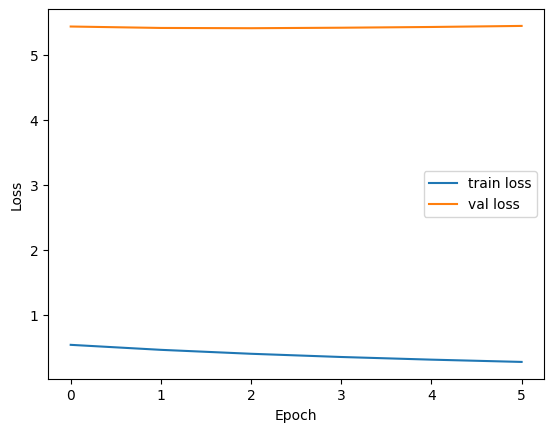

In [200]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [212]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3, 
    restore_best_weights=True
)

history = model.fit(
    x=[x_user, x_movie],
    y=y,
    epochs=50,  # možeš više, nećeš brinuti o overfittingu
    batch_size=1024,
    validation_data=([x_user_dev, x_movie_dev], y_dev),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 125ms/step - loss: 0.3270 - val_loss: 5.4265
Epoch 2/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 0.2846 - val_loss: 5.4396
Epoch 3/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 124ms/step - loss: 0.2508 - val_loss: 5.4581
Epoch 4/50
569/569 ━━━━━━━━━━━━━━━━━━━━ 71s 125ms/step - loss: 0.2240 - val_loss: 5.4716


### NN COLABORATIVE FILTER

In [461]:
y = df.select(pl.col('rating')).to_numpy()
X_user = df.select(unique_genres)
X_movie = df.select(pl.all().exclude(['movieId','title', *user_feature.columns,'rating']))

In [463]:
X_movie

#ratings_film,year,avg_rating,(no genres listed)_right,Action_right,Adventure_right,Animation_right,Children_right,Comedy_right,Crime_right,Documentary_right,Drama_right,Fantasy_right,Film-Noir_right,Horror_right,IMAX_right,Musical_right,Mystery_right,Romance_right,Sci-Fi_right,Thriller_right,War_right,Western_right
u32,i16,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
68997,1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
68997,1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
68997,1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
68997,1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
68997,1995,3.7875,0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
46,2023,3.2875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
46,2023,3.2875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0
46,2023,3.2875,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0


In [465]:
SS_movie = StandardScaler()
SS_user = StandardScaler()

In [467]:
movie_num = SS_movie.fit_transform(X_movie[:,:3])
movie_cat = X_movie.select(pl.all().exclude(['#ratings_film', 'year', 'avg_rating'])).to_numpy()
X_movie_numpy = np.column_stack([movie_num,movie_cat])

In [469]:
X_user_numpy = SS_user.fit_transform(X_user)

In [470]:
X_user.shape, X_movie.shape, y.shape

((694000, 20), (694000, 23), (694000, 1))

In [487]:
num_user_features = X_user_numpy.shape[1]   
num_movie_features = X_movie_numpy.shape[1]
drop = 0.2
# ---------------- USER TOWER ----------------
user_input = layers.Input(shape=(num_user_features,), name='user_input')

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(user_input)
x = layers.Dropout(drop)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)

user_embedding = layers.Dense(32, activation='linear', name='user_embedding')(x)

# ---------------- MOVIE TOWER ----------------
movie_input = layers.Input(shape=(num_movie_features,), name='movie_input')

x2= layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(movie_input)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)

movie_embedding = layers.Dense(32, activation='linear', name='movie_embedding')(x2)

# ---------------- FINAL MODEL ----------------
dot_product = layers.Dot(axes=1, name='dot_product')([user_embedding, movie_embedding])

model = models.Model(inputs=[user_input, movie_input], outputs=dot_product)

# Compile model
model.compile(optimizer='adam', loss='mse')

# Pregled modela
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 23)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_42 (Dense)              │ (None, 128)               │           2,688 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_45 (Dense)              │ (None, 128)               │           3,072 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_42 (Dropout)          │ (None, 128)               │               0 │ dense_42[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_45 (Dropout)          │ (None, 128)               │               0 │ dense_45[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_43 (Dense)              │ (None, 64)                │           8,256 │ dropout_42[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_46 (Dense)              │ (None, 64)                │           8,256 │ dropout_45[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_43 (Dropout)          │ (None, 64)                │               0 │ dense_43[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_46 (Dropout)          │ (None, 64)                │               0 │ dense_46[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_44 (Dense)              │ (None, 32)                │           2,080 │ dropout_43[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_47 (Dense)              │ (None, 32)                │           2,080 │ dropout_46[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_44 (Dropout)          │ (None, 32)                │               0 │ dense_44[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_47 (Dropout)          │ (None, 32)                │               0 │ dense_47[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Dense)        │ (None, 32)                │           1,056 │ dropout_44[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_embedding (Dense)       │ (None, 32)                │           1,056 │ dropout_47[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dot_product (Dot)             │ (None, 1)                 │               0 │ user_embedding[0][0],      │
│                               │                           │               

 Total params: 28,544 (111.50 KB)

 Trainable params: 28,544 (111.50 KB)

 Non-trainable params: 0 (0.00 B)

In [489]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# EarlyStopping - prekida kad 5 epoha za redom nema poboljšanja
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# ReduceLROnPlateau - smanjuje learning rate ako validacija stagnira
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,  # smanji lr za 50%
    patience=3, # ako 3 epohe zaredom nema poboljšanja
    verbose=1
)

# Treniraj model
history = model.fit(
    [X_user_numpy, X_movie_numpy],
    y,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

Epoch 1/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 1.0784 - val_loss: 0.7256 - learning_rate: 0.0010
Epoch 2/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 49s 3ms/step - loss: 0.6943 - val_loss: 0.7137 - learning_rate: 0.0010
Epoch 3/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.6865 - val_loss: 0.7107 - learning_rate: 0.0010
Epoch 4/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.6842 - val_loss: 0.7044 - learning_rate: 0.0010
Epoch 5/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.6862 - val_loss: 0.6948 - learning_rate: 0.0010
Epoch 6/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.6821 - val_loss: 0.6984 - learning_rate: 0.0010
Epoch 7/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms/step - loss: 0.6841 - val_loss: 0.7228 - learning_rate: 0.0010
Epoch 8/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.6793
Epoch 8: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 44s 3ms

In [497]:

# ---------------- USER TOWER ----------------
user_input = layers.Input(shape=(num_user_features,), name='user_input')

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(user_input)
x = layers.Dropout(drop)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)
x = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)

user_embedding = layers.Dense(20, activation='linear', name='user_embedding')(x)

# ---------------- MOVIE TOWER ----------------
movie_input = layers.Input(shape=(num_movie_features,), name='movie_input')
x2= layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(movie_input)
x2 = layers.Dropout(drop)(x2)
x2= layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)

movie_embedding = layers.Dense(20, activation='linear', name='movie_embedding')(x2)

# ---------------- FINAL MODEL ----------------
dot_product = layers.Dot(axes=1, name='dot_product')([user_embedding, movie_embedding])

model2 = models.Model(inputs=[user_input, movie_input], outputs=dot_product)

# Compile model
model2.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Pregled modela
model2.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 23)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_72 (Dense)              │ (None, 256)               │           5,376 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_76 (Dense)              │ (None, 128)               │           3,072 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_72 (Dropout)          │ (None, 256)               │               0 │ dense_72[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_76 (Dropout)          │ (None, 128)               │               0 │ dense_76[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_73 (Dense)              │ (None, 128)               │          32,896 │ dropout_72[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_77 (Dense)              │ (None, 128)               │          16,512 │ dropout_76[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_73 (Dropout)          │ (None, 128)               │               0 │ dense_73[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_77 (Dropout)          │ (None, 128)               │               0 │ dense_77[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_74 (Dense)              │ (None, 64)                │           8,256 │ dropout_73[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_78 (Dense)              │ (None, 64)                │           8,256 │ dropout_77[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_74 (Dropout)          │ (None, 64)                │               0 │ dense_74[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_78 (Dropout)          │ (None, 64)                │               0 │ dense_78[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_75 (Dense)              │ (None, 32)                │           2,080 │ dropout_74[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_79 (Dense)              │ (None, 32)                │           2,080 │ dropout_78[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_75 (Dropout)          │ (None, 32)                │               0 │ dense_75[0][0]             │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 79,848 (311.91 KB)

 Trainable params: 79,848 (311.91 KB)

 Non-trainable params: 0 (0.00 B)

In [501]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=3, verbose=1)

history = model2.fit([X_user_numpy, X_movie_numpy], y, epochs=150, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 66s 3ms/step - loss: 1.1770 - mae: 0.7306 - mse: 0.9303 - val_loss: 0.7600 - val_mae: 0.6452 - val_mse: 0.7224 - learning_rate: 0.0010
Epoch 2/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.7478 - mae: 0.6421 - mse: 0.7112 - val_loss: 0.7506 - val_mae: 0.6349 - val_mse: 0.7165 - learning_rate: 0.0010
Epoch 3/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 0.7400 - mae: 0.6388 - mse: 0.7050 - val_loss: 0.7631 - val_mae: 0.6280 - val_mse: 0.7278 - learning_rate: 0.0010
Epoch 4/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.7363 - mae: 0.6373 - mse: 0.7021 - val_loss: 0.7445 - val_mae: 0.6256 - val_mse: 0.7109 - learning_rate: 0.0010
Epoch 5/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 57s 3ms/step - loss: 0.7359 - mae: 0.6370 - mse: 0.7022 - val_loss: 0.7338 - val_mae: 0.6264 - val_mse: 0.7000 - learning_rate: 0.0010
Epoch 6/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 56s 3ms/step - loss: 0.7352 - mae: 0.6371 - mse: 0.7015

KeyboardInterrupt: 

In [509]:
model2.save('model2.keras')

In [511]:
history.save

AttributeError: 'History' object has no attribute 'save'

In [531]:

# ---------------- USER TOWER ----------------
user_input = layers.Input(shape=(num_user_features,), name='user_input')

x = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(user_input)
x = layers.Dropout(drop)(x)
x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)
x = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)
x = layers.Dense(60, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x)
x = layers.Dropout(drop)(x)

user_embedding = layers.Dense(60, activation='linear', name='user_embedding')(x)

# ---------------- MOVIE TOWER ----------------
movie_input = layers.Input(shape=(num_movie_features,), name='movie_input')
x2= layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001))(movie_input)
x2 = layers.Dropout(drop)(x2)
x2= layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(60, activation='relu', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = layers.Dropout(drop)(x2)

movie_embedding = layers.Dense(60, activation='linear', name='movie_embedding')(x2)

# ---------------- FINAL MODEL ----------------
dot_product = layers.Dot(axes=1, name='dot_product')([user_embedding, movie_embedding])

model3 = models.Model(inputs=[user_input, movie_input], outputs=dot_product)

# Compile model
model3.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Pregled modela
model3.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 23)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_112 (Dense)             │ (None, 256)               │           5,376 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_116 (Dense)             │ (None, 256)               │           6,144 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_112 (Dropout)         │ (None, 256)               │               0 │ dense_112[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_116 (Dropout)         │ (None, 256)               │               0 │ dense_116[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_113 (Dense)             │ (None, 128)               │          32,896 │ dropout_112[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_117 (Dense)             │ (None, 128)               │          32,896 │ dropout_116[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_113 (Dropout)         │ (None, 128)               │               0 │ dense_113[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_117 (Dropout)         │ (None, 128)               │               0 │ dense_117[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_114 (Dense)             │ (None, 64)                │           8,256 │ dropout_113[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_118 (Dense)             │ (None, 64)                │           8,256 │ dropout_117[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_114 (Dropout)         │ (None, 64)                │               0 │ dense_114[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_118 (Dropout)         │ (None, 64)                │               0 │ dense_118[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_115 (Dense)             │ (None, 60)                │           3,900 │ dropout_114[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_119 (Dense)             │ (None, 60)                │           3,900 │ dropout_118[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_115 (Dropout)         │ (None, 60)                │               0 │ dense_115[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 108,944 (425.56 KB)

 Trainable params: 108,944 (425.56 KB)

 Non-trainable params: 0 (0.00 B)

In [533]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=1/3, patience=3, verbose=1)

history3 = model3.fit([X_user_numpy, X_movie_numpy], y, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr], verbose=1)

Epoch 1/50
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 69s 4ms/step - loss: 1.1370 - mae: 0.7069 - mse: 0.8654 - val_loss: 0.7473 - val_mae: 0.6310 - val_mse: 0.7084 - learning_rate: 0.0010
Epoch 2/50
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 62s 4ms/step - loss: 0.7369 - mae: 0.6355 - mse: 0.6997 - val_loss: 0.7569 - val_mae: 0.6438 - val_mse: 0.7207 - learning_rate: 0.0010
Epoch 3/50
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 67s 4ms/step - loss: 0.7287 - mae: 0.6324 - mse: 0.6927 - val_loss: 0.7424 - val_mae: 0.6195 - val_mse: 0.7064 - learning_rate: 0.0010
Epoch 4/50
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 70s 4ms/step - loss: 0.7278 - mae: 0.6308 - mse: 0.6921 - val_loss: 0.7417 - val_mae: 0.6304 - val_mse: 0.7060 - learning_rate: 0.0010
Epoch 5/50
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 0.7260 - mae: 0.6296 - mse: 0.6908 - val_loss: 0.7700 - val_mae: 0.6509 - val_mse: 0.7352 - learning_rate: 0.0010
Epoch 6/50
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - loss: 0.7274 - mae: 0.6312 - mse: 0.6921 - val

KeyboardInterrupt: 

In [539]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard_callback = TensorBoard(
    log_dir="./logs",
    histogram_freq=1,  # Loguj histograme svaki epoch
    write_graph=True,
    write_images=True,
    update_freq='epoch'
)

# Pa ubaciš ga u callbacks:
history3 = model3.fit(
    [X_user_numpy, X_movie_numpy],
    y,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr, tensorboard_callback],
    verbose=1
)


Epoch 1/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 81s 5ms/step - loss: 0.6891 - mae: 0.6135 - mse: 0.6618 - val_loss: 0.7314 - val_mae: 0.6348 - val_mse: 0.7059 - learning_rate: 3.3333e-04
Epoch 2/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 79s 5ms/step - loss: 0.6900 - mae: 0.6147 - mse: 0.6643 - val_loss: 0.7345 - val_mae: 0.6352 - val_mse: 0.7092 - learning_rate: 3.3333e-04
Epoch 3/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 82s 5ms/step - loss: 0.6856 - mae: 0.6125 - mse: 0.6604 - val_loss: 0.7198 - val_mae: 0.6253 - val_mse: 0.6952 - learning_rate: 3.3333e-04
Epoch 4/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 84s 5ms/step - loss: 0.6861 - mae: 0.6139 - mse: 0.6613 - val_loss: 0.7195 - val_mae: 0.6274 - val_mse: 0.6949 - learning_rate: 3.3333e-04
Epoch 5/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 0.6874 - mae: 0.6143 - mse: 0.6629 - val_loss: 0.7209 - val_mae: 0.6263 - val_mse: 0.6967 - learning_rate: 3.3333e-04
Epoch 6/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 71s 4ms/step - loss: 0.6881 - mae: 

KeyboardInterrupt: 

In [ ]:
model3.save('model3.keras')

In [541]:
import matplotlib.pyplot as plt

plt.plot(history3.history['loss'], label='train loss')
plt.plot(history3.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

NameError: name 'history3' is not defined

### SKIDAM REGULARIZACIJU SA POSLEDNJA 2 SLOJA

In [556]:
num_user_features = X_user_numpy.shape[1]   
num_movie_features = X_movie_numpy.shape[1]
drop = 0.2
# ---------------- USER TOWER ----------------
user_input = layers.Input(shape=(num_user_features,), name='user_input')

x = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(user_input)
x = layers.Dropout(drop)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(drop)(x)
x = layers.Dense(32, activation='relu')(x)
x = layers.Dropout(drop)(x)

user_embedding = layers.Dense(32, activation='linear', name='user_embedding')(x)

# ---------------- MOVIE TOWER ----------------
movie_input = layers.Input(shape=(num_movie_features,), name='movie_input')

x2= layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001))(movie_input)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(64, activation='relu')(x2)
x2 = layers.Dropout(drop)(x2)
x2 = layers.Dense(32, activation='relu')(x2)
x2 = layers.Dropout(drop)(x2)

movie_embedding = layers.Dense(32, activation='linear', name='movie_embedding')(x2)

# ---------------- FINAL MODEL ----------------
dot_product = layers.Dot(axes=1, name='dot_product')([user_embedding, movie_embedding])

model4 = models.Model(inputs=[user_input, movie_input], outputs=dot_product)

# Compile model
model4.compile(optimizer='adam', loss='mse', metrics=['mae', 'mse'])

# Pregled modela
model4.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ user_input (InputLayer)       │ (None, 20)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_input (InputLayer)      │ (None, 23)                │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_132 (Dense)             │ (None, 128)               │           2,688 │ user_input[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_135 (Dense)             │ (None, 128)               │           3,072 │ movie_input[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_132 (Dropout)         │ (None, 128)               │               0 │ dense_132[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_135 (Dropout)         │ (None, 128)               │               0 │ dense_135[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_133 (Dense)             │ (None, 64)                │           8,256 │ dropout_132[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_136 (Dense)             │ (None, 64)                │           8,256 │ dropout_135[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_133 (Dropout)         │ (None, 64)                │               0 │ dense_133[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_136 (Dropout)         │ (None, 64)                │               0 │ dense_136[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_134 (Dense)             │ (None, 32)                │           2,080 │ dropout_133[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_137 (Dense)             │ (None, 32)                │           2,080 │ dropout_136[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_134 (Dropout)         │ (None, 32)                │               0 │ dense_134[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_137 (Dropout)         │ (None, 32)                │               0 │ dense_137[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ user_embedding (Dense)        │ (None, 32)                │           1,056 │ dropout_134[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ movie_embedding (Dense)       │ (None, 32)                │           1,056 │ dropout_137[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dot_product (Dot)             │ (None, 1)                 │               0 │ user_embedding[0][0],      │
│                               │                           │               

 Total params: 28,544 (111.50 KB)

 Trainable params: 28,544 (111.50 KB)

 Non-trainable params: 0 (0.00 B)

In [558]:
tensorboard_callback = TensorBoard(
    histogram_freq=1,         # beleži histograme težina svakih 1 epoch
    write_graph=True,         # čuva graf mreže
    write_images=True,        # čuva slike težina
    update_freq='epoch',      # ažurira posle svake epohe
)

# --- EarlyStopping ---
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

# --- ReduceLROnPlateau ---
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1
)

# --- Treniraj model ---
history4 = model4.fit(
    [X_user_numpy, X_movie_numpy],
    y,
    epochs=150,
    batch_size=32,
    validation_split=0.2,
    callbacks=[tensorboard_callback, early_stopping, reduce_lr],
    verbose=1)

Epoch 1/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - loss: 0.9667 - mae: 0.7256 - mse: 0.9262 - val_loss: 0.7207 - val_mae: 0.6397 - val_mse: 0.7043 - learning_rate: 0.0010
Epoch 2/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 61s 3ms/step - loss: 0.6734 - mae: 0.6155 - mse: 0.6573 - val_loss: 0.6877 - val_mae: 0.6163 - val_mse: 0.6719 - learning_rate: 0.0010
Epoch 3/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 0.6612 - mae: 0.6083 - mse: 0.6453 - val_loss: 0.6960 - val_mae: 0.6244 - val_mse: 0.6802 - learning_rate: 0.0010
Epoch 4/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 0.6529 - mae: 0.6042 - mse: 0.6371 - val_loss: 0.6707 - val_mae: 0.6032 - val_mse: 0.6548 - learning_rate: 0.0010
Epoch 5/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 0.6498 - mae: 0.6021 - mse: 0.6340 - val_loss: 0.6933 - val_mae: 0.6332 - val_mse: 0.6782 - learning_rate: 0.0010
Epoch 6/150
17350/17350 ━━━━━━━━━━━━━━━━━━━━ 60s 3ms/step - loss: 0.6439 - mae: 0.5999 - mse: 0.6286

In [560]:
model4.save('model4_bestModel.keras')

In [569]:
joblib.dump(history4, 'model4_history.pkl')

['model4_history.pkl']

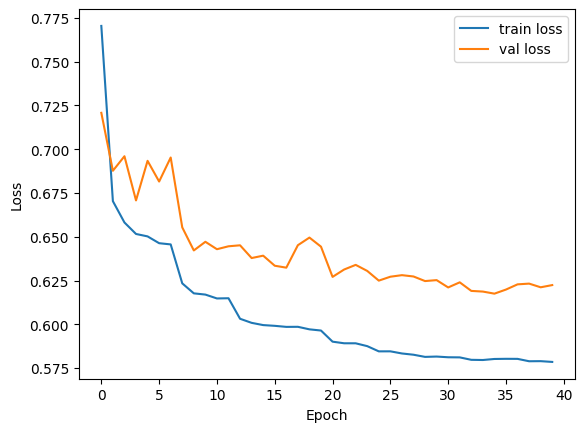

In [561]:
plt.plot(history4.history['loss'], label='train loss')
plt.plot(history4.history['val_loss'], label='val loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

['.ipynb_checkpoints',
 'Film.ipynb',
 'logs',
 'ml-32m',
 'model2.keras',
 'model4_bestModel.keras',
 'model4_history.pkl',
 'model_content_based.h5',
 'model_content_based.keras']

In [588]:
b = keras.models.load_model('model4_bestModel.keras')

In [600]:
len(b.get_weights())

16

In [610]:
for i in b.get_weights():
    print(i.shape)

(20, 128)
(128,)
(23, 128)
(128,)
(128, 64)
(64,)
(128, 64)
(64,)
(64, 32)
(32,)
(64, 32)
(32,)
(32, 32)
(32,)
(32, 32)
(32,)


In [581]:
joblib.load('model4_history.pkl')

In [255]:
model.predict((X_user[10].reshape(1,-1), X_movie[10].reshape(1,-1)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


array([[0.1426981]], dtype=float32)

In [335]:
X_movie[10].reshape(1,-1)

array([[12.24547033,  0.03811556,  1.08235658,  0.        ,  0.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  0.        ,
         0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ]])

In [345]:
X_user[10].reshape(1,-1)

AttributeError: 'DataFrame' object has no attribute 'reshape'

In [257]:
X_user[10]

array([-0.54627892, -1.66744998,  0.12091797,  0.44143685,  0.46259695,
       -0.29703452, -1.59569312, -1.05931267, -2.93611269,  0.26693204,
       -0.56776599, -1.25123463, -0.56450595, -0.91585002, -1.27535158,
       -1.73221951, -1.31843408, -1.85172194, -1.04109284, -0.77862885])

In [327]:
user_feature[10]

userId,Horror,Romance,Thriller,Drama,Action,Musical,Sci-Fi,Comedy,Adventure,Animation,Crime,Fantasy,Film-Noir,IMAX,War,Documentary,Mystery,Western,Children,(no genres listed)
i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
66699,0.0,0.0,0.0,1.5,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0,1.5,0.0,0.0,0.0,0.0,0.0,0.0


In [333]:
movie_features[10]

movieId,title,year,avg_rating,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
i64,str,i16,f64,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
11,"""American President, The (1995)""",1995,3.6875,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0


In [192]:
predicted_rating

array([[3.2768624]], dtype=float32)

In [180]:
predicted_rating

array([[3.2768624]], dtype=float32)

In [289]:
X_user[10:11].shape, X_user[10].reshape(1,-1).shape

((1, 20), (1, 20))

In [291]:
b = SS_user.inverse_transform(X_user[10:11])

In [297]:
b.round(4)

array([[ 0. ,  0. ,  2.5,  2.5,  2.5,  2.5,  0. , -0. ,  0. ,  2.5,  0. ,
         0. , -0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ]])

In [313]:
SS_movie.inverse_transform(X_movie[10:11,:3]).round(6)

array([[6.8997e+04, 1.9950e+03, 3.7875e+00]])

In [172]:
X_user[10].shape, X_movie[10].shape

((20,), (23,))

In [176]:
zip(X_user[10], X_movie[10])

In [384]:
y.shape

(582540, 1)

In [352]:
y

<KerasTensor shape=(None, 32), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>